In [ ]:
import numpy as np
import networkx as nx
from networkx.algorithms.traversal.depth_first_search import dfs_tree
import matplotlib.pyplot as plt
from scipy.optimize import linprog

Задание 2. Константинов Даниил

In [ ]:
# загрузка исходных данных для графов
! git clone https://github.com/CI314X/Data-Vizualization

## Алгоритма Грэхема—Коффмана.

In [ ]:
# первый этап
def first_stage():
    global G, nodes_nam_lab
    
    nodes_nam_lab[list(G.nodes())[0]] = 1  # взяли первого
    number = 2
    parents = dict()  # (соседи V_1), (соседи V_2)
    for v in G.nodes():
        parents[v] = [x[0] for x in G.in_edges(v)]
    for _ in range(len(G) - 1):
        # обновим метки соседей, для выбора лексикографич. минимального
        new_neighb = dict()
        for v in G.nodes():
            if nodes_nam_lab[v] > len(G) + 100:   # неотмеченная метка
                help_labels = []
                for x in parents[v]:
                    help_labels.append(nodes_nam_lab[x])
                new_neighb[v] = sorted(help_labels, reverse = True)
        name = min(new_neighb, key=new_neighb.get)
        nodes_nam_lab[name] = number
        number += 1
    return


def get_maximum_num(U, remain):
    global G, nodes_nam_lab
    max_num = -1
    name_ret = ""
    for x in remain:
        neighb = set([i[1] for i in G.out_edges(x)])
        if nodes_nam_lab[x] > max_num and neighb.issubset(U):
            max_num = nodes_nam_lab[x]
            name_ret = x
    neighb = set([i[1] for i in G.out_edges(name_ret)])
    return name_ret, neighb
    
    
def second_stage(WIDTH):
    global G, nodes_nam_lab
    k = 0
    U = set()
    V = set(G.nodes())
    Layers = [set([])]
    while U != V:
        remain = V - U
        name_v, childs_v = get_maximum_num(U, remain)
        isExistChildsinLayer = False
        for v in childs_v:
            if v in Layers[k]:
                isExistChildsinLayer = True
        if len(Layers[k]) < WIDTH and not isExistChildsinLayer:
            Layers[k].add(name_v)
        else:
            k += 1
            Layers.append(set([name_v]))
        
        U.add(name_v)
    return Layers

In [ ]:
# name_dummy = f"dum_{number}"
# добавляет фиктивные вершины
def add_dummy_vertex(G, layers):
    new_G = G.copy()
    new_layers = layers.copy()
    t = 0  # номер для присваивания dummy вершинам
    for k in range(len(new_layers) - 1):  # пробегаем по слоям
        for v1 in new_layers[k]:
            out_vertex = [i[1] for i in new_G.out_edges(v1)]   # куда из нее ведут ребра
            for v2 in out_vertex:
                if v2 not in new_layers[k + 1]: # если конец ребра не лежит в следующем слое
                    name_n = f"dum_{t}"
                    
                    t += 1
                    new_layers[k + 1].add(name_n)
                    new_G.add_node(name_n)
                    new_G.remove_edge(v1, v2)
                    new_G.add_edge(v1, name_n)
                    new_G.add_edge(name_n, v2)
    return new_G, new_layers

# инициация координат
def init_coord(G, layers): 
    x_coord = {v: 0 for v in new_G.nodes()}
    y_coord = {v: 0 for v in new_G.nodes()}
    max_y = 0

    for layer in layers:
        x_coordinate = 0
        for v in layer:
            x_coord[v] = x_coordinate
            y_coord[v] = max_y
            x_coordinate += 1
        max_y -= 1
    return x_coord, y_coord

# эвристически проводим перестановку вершин (по среднему от родителей)
def heuristic1(G, layers, x_coord):
    x_new_coord = x_coord.copy()
    for layer in layers[1:]:  # со второго слоя
        x_curr_layer = []
        for v in layer:
            parents_coord = [x_new_coord[x[0]] for x in G.in_edges(v)]
            if len(parents_coord) > 0:
                candid = sum(parents_coord) / len(parents_coord)
                if len(x_curr_layer) == 0 or candid not in x_curr_layer:
                    x_new_coord[v] = candid
                else:
                    num = len(np.where(x_curr_layer == candid))
                    x_new_coord[v] = candid + num * 0.1

                x_curr_layer.append(x_new_coord[v])
    
    # калибровка координат в числа от 0 до 2
    #max_length_layer = max([len(x) for x in layers])
    for layer in layers[1:]:
        curr_coord = {x: x_new_coord[x] for x in layer}
        curr_coord = {k: v for k, v in sorted(curr_coord.items(), key=lambda item: item[1])}
        if len(layer) != 1:
            step = 2 / (len(layer))
        else:
            step = 0
        s = 0
        for v in curr_coord:
            x_new_coord[v] = s
            s += step

    return x_new_coord


# число пересечений при перестановке двух вершин в слое
def num_crossings(x_coord, v, w, G, L_upper, L_middle, L_bottom):
    l1 = L_upper.copy()
    l2 = L_middle.copy()
    l3 = L_bottom.copy()
    coord_l1 = {x: x_coord[x] for x in l1}
    coord_l1 = {k: v for k, v in sorted(coord_l1.items(), key=lambda item: item[1])}
    l11 = {i: x for i, x in enumerate(coord_l1)}
    coord_l2 = {x: x_coord[x] for x in l2}
    coord_l2 = {k: v for k, v in sorted(coord_l2.items(), key=lambda item: item[1])}
    l22 = {i: x for i, x in enumerate(coord_l2)}
    coord_l3 = {x: x_coord[x] for x in l3}
    coord_l3 = {k: v for k, v in sorted(coord_l3.items(), key=lambda item: item[1])}
    l33 = {i: x for i, x in enumerate(coord_l3)}
    # считаем без перестановки
    old_CROSS = 0
    for x1 in range(1, len(coord_l1)):
        for x2 in range(len(coord_l2)):
            for x11 in range(x1):
                for x22 in range(x2 + 1, len(coord_l2)):
                    if (l11[x11],l22[x22]) in G.edges():
                        old_CROSS += 1

    # считаем с перестановкой
    coord_l2 = {x: x_coord[x] for x in l2}
    #print(coord_l2, v, w)
    coord_l2[v], coord_l2[w] = coord_l2[w], coord_l2[v]
    coord_l2 = {k: v for k, v in sorted(coord_l2.items(), key=lambda item: item[1])}
    l22 = {i: x for i, x in enumerate(coord_l2)}
    new_CROSS = 0
    for x1 in range(1, len(coord_l1)):
        for x2 in range(len(coord_l2)):
            for x11 in range(x1):
                for x22 in range(x2 + 1, len(coord_l2)):
                    if (l11[x11],l22[x22]) in G.edges():
                        new_CROSS += 1
    return old_CROSS, new_CROSS

# перестановка вершин в слое
def exchange_local_search(G, x_coord, L_upper, L_middle, L_bottom):
    l1 = L_upper.copy()
    l2 = L_middle.copy()
    l22 = {i: x for i, x in enumerate(l2)}
    l3 = L_bottom.copy()
    for v in range(len(l2) - 1):
        for w in range(v + 1, len(l2)):
            num_cross_old, num_cross_new = num_crossings(x_coord, l22[v], l22[w], G, l1, l2, l3)
            if num_cross_new < num_cross_old:
                x_coord[l22[v]], x_coord[l22[w]] = x_coord[l22[w]], x_coord[l22[v]]
    return l2
            
# локальный поиск пересечений и перестановка вершин
def heuristic1_local_search(G, Layers, x_coord):
    layers = Layers.copy()
    # идем снизу вверх
    for _ in range(4):
        for i in range(1, len(layers) - 1):
            layers[i] = exchange_local_search(G, x_coord, layers[i - 1], layers[i], layers[i + 1])

        for i in range(len(layers) - 2, 1, -1):
            layers[i] = exchange_local_search(G, x_coord, layers[i + 1], layers[i], layers[i - 1])
    return layers

In [ ]:
# загрузка файла
test_file = 'Data-Vizualization/small_dag.graphml'  # название файла для загрузки  
#test_file = 'Data-Vizualization/big_dag.graphml'    # на этом примере лучше видна работа по минимизации вершин

# за примеры выше благодарность Антону Рыбьянову

#test_file = 'Data-Vizualization/graph_lect_2.xml'  # граф с лекции
# обработка файла
g_read = nx.read_graphml(test_file)
G = nx.DiGraph()
G.add_nodes_from(g_read.nodes())
G.add_edges_from(g_read.edges())

/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:946: UserWarning: No key type for id d4. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:946: UserWarning: No key type for id d5. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:946: UserWarning: No key type for id d6. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:946: UserWarning: No key type for id d7. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:946: UserWarning: No key type for id d8. Using string
  warnings.warn(f"No key type for id {attr_id}. Using string")
/usr/local/lib/python3.7/dist-packages/networkx/readwrite/graphml.py:9

### При заданной ширине

In [ ]:
WIDTH = 3 # ширина

In [ ]:
nodes_nam_lab = {x: 1e8 for x in G.nodes()}
first_stage()
layers = second_stage(WIDTH)
layers.reverse()
new_G, layers = add_dummy_vertex(G, layers)
x_coord, y_coord = init_coord(new_G, layers)
x_coord = heuristic1(new_G, layers, x_coord)
layers = heuristic1_local_search(new_G, layers, x_coord)

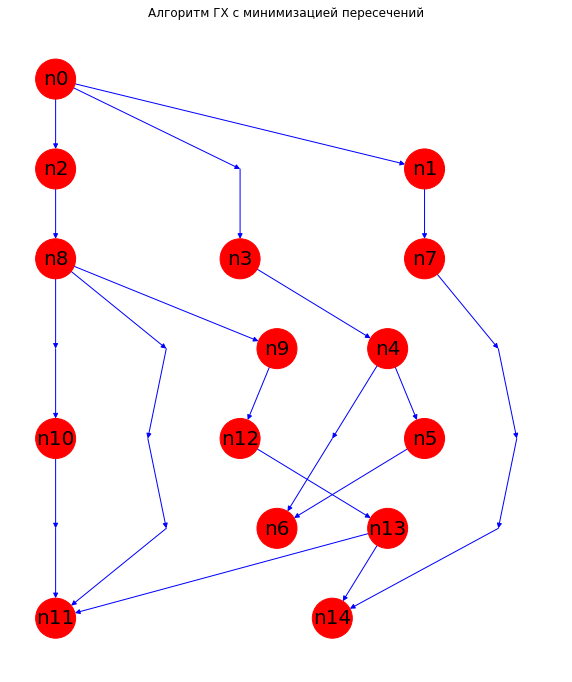

In [ ]:
pos = {}
node_size = []
labels = {}
for v in new_G.nodes():
    pos[v] = [x_coord[v], y_coord[v]]
    if v[:3] == "dum":
        node_size.append(0)
        labels[v] = ""
    else:
        node_size.append(1600)
        labels[v] = v
plt.figure(figsize=(10,12))  # возможно, тут в зависимости от графа нужно поменять значения для эстетического удовольствия
plt.title('Алгоритм ГХ с минимизацией пересечений')
width = 1  # ширина линий
nx.draw(new_G, pos=pos, with_labels=True, labels=labels,font_size=20, node_size=node_size, node_color='red', edge_color='b', width=width)
plt.savefig("GC.png")
plt.show()

In [ ]:
s = 0
for v in new_G.nodes():
    if v[:3] == "dum":
        s += 1
print(f"Dummy вершин = {s}")

Dummy вершин = 10


###  Без заданной ширины (с минимизацией количества dummy вершин)

In [ ]:
bounds = [(1, len(G.nodes()))] * (len(G.nodes()) + 1)
c = [0] * (len(G.nodes()) + 1)  # последний столбец для константы
c[-1] = 0
nodes_labels = {x: i for i, x in enumerate(G.nodes())}
labels_nodes = {i: x for i, x in enumerate(G.nodes())}
A_ub = np.zeros((len(G.edges()), len(c)))
b_ub = [0] * len(G.edges())
for i, e in enumerate(G.edges()):
    y_u, y_v = nodes_labels[e[0]], nodes_labels[e[1]]
    c[-1] -= 1
    c[y_u] += 1
    c[y_v] -= 1
    A_ub[i][-1] = 1
    A_ub[i][y_u] = -1
    A_ub[i][y_v] = 1
    
res = linprog(c, A_ub=A_ub, b_ub=b_ub, bounds=bounds)

# округлим координаты
y_coord = {v: 0 for v in G.nodes()}
for i, y in enumerate(res.x[:-1]):
    y_coord[labels_nodes[i]] = int(round(y))

y_coord = {k: v for k, v in sorted(y_coord.items(), key=lambda item: item[1])}  # упорядочивание по значениям
# создание набора слоёв
layers = [set()]
curr_layer = 1
curr_y = min(y_coord.values())
for v in y_coord:
    if y_coord[v] > curr_y:
        curr_layer += 1
        layers.append(set([v]))
        curr_y = y_coord[v]
    else:
        layers[curr_layer - 1].add(v)
layers.reverse()

# начало процедуры добавления dummy вершин и минимизация пересечений
new_G, layers = add_dummy_vertex(G, layers)
x_coord, y_coord = init_coord(new_G, layers)
x_coord = heuristic1(new_G, layers, x_coord)
layers = heuristic1_local_search(new_G, layers, x_coord)

/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:87: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


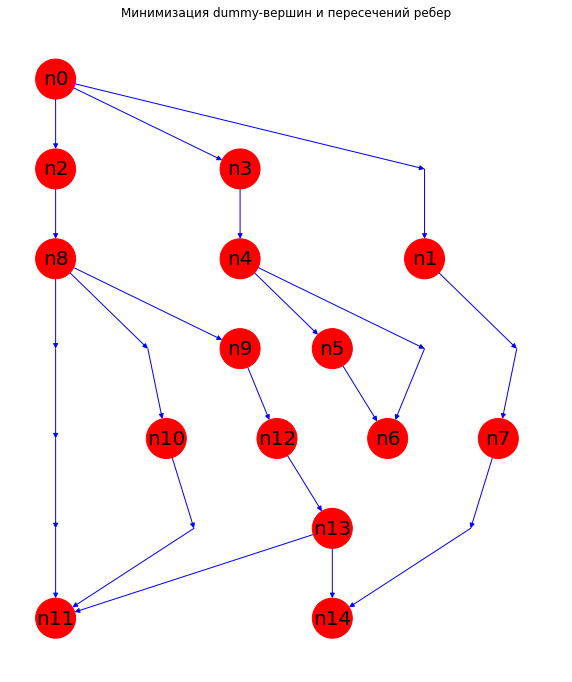

In [ ]:
pos = {}
node_size = []
labels = {}
for v in new_G.nodes():
    pos[v] = [x_coord[v], y_coord[v]]
    if v[:3] == "dum":
        node_size.append(0)
        labels[v] = ""
    else:
        node_size.append(1600)
        labels[v] = v
plt.figure(figsize=(10,12))  # возможно, тут в зависимости от графа нужно поменять значения для эстетического удовольствия
plt.title('Минимизация dummy-вершин и пересечений ребер')
width = 1  # ширина линий
nx.draw(new_G, pos=pos, with_labels=True, labels=labels,font_size=20, node_size=node_size, node_color='red', edge_color='b', width=width)
plt.savefig("min dummy.png")
plt.show()

In [ ]:
s = 0
for v in new_G.nodes():
    if v[:3] == "dum":
        s += 1
print(f"Dummy вершин = {s}")

Dummy вершин = 9
